In [1]:
%load_ext autoreload
%autoreload 2
from dateutil import rrule
from datetime import date, datetime, timedelta
import pandas as pd
import pickle as pkl
import random
import matplotlib.pyplot as plt
import fastplot
import seaborn as sns
import scipy
import numpy as np
import instagram_utils as utils
import statsmodels.api as sm
from sklearn import linear_model
import itertools
import math
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

# NMI Communities

In [2]:
list_models = ['Original','NC', 'TriBE', 'MLF', 'GloSS', 'SDSM']
dict_names = {'Original': 'Original Network', 'NC': "NC's backbone", 
              'TriBE': "TriBE's backbone", 'MLF': "MLF's backbone", 
              'GloSS': "GloSS's backbone", 'SDSM':"SDSM's backbone"}


#Base on the most aggressive method: GloSS
tribe = 1-0.05
sdsm= 0.001 
gloss = 0.1
mlf = 0.001
nc = 1-0.00001
dict_models = {'Original':'', 'NC':nc, 'TriBE':tribe, 'MLF':mlf, 'GloSS':gloss, 'SDSM':sdsm}

PATH_Networks = 'Instagram-BR/backbones/'
PATH_Communities = 'Instagram-BR/communities/'
list_results = []
for model_1 in list_models:
    for model_2 in list_models:
        if model_1 == 'Original':
            comm_1 = pkl.load(open(PATH_Communities+model_1+'.pkl', "rb")) 
        else:
            comm_1 = pkl.load(open(PATH_Communities+model_1+'-'+str(dict_models[model_1])+'.pkl', "rb")) 
            
        if model_2 == 'Original':
            comm_2 = pkl.load(open(PATH_Communities+model_2+'.pkl', "rb")) 
        else:
            comm_2 = pkl.load(open(PATH_Communities+model_2+'-'+str(dict_models[model_2])+'.pkl', "rb")) 
        
        comm_1 = {int(k):int(v) for k,v in comm_1.items()}
        comm_2 = {int(k):int(v) for k,v in comm_2.items()}
        common_nodes = set(comm_1.keys()) & set(comm_2.keys())
        list_id_1 = []
        list_id_2 = []
        for node in common_nodes:
            list_id_1.append(comm_1[node])
            list_id_2.append(comm_2[node])
        nmi = round(normalized_mutual_info_score(list_id_1, list_id_2),4)
        list_results.append((dict_names[model_1], dict_names[model_2], nmi))
df = pd.DataFrame(list_results, columns = ['Model 1', 'Model 2', 'NMI'])

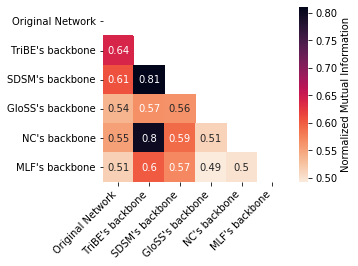

In [3]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 3.8))
sorter = ['Original Network', "TriBE's backbone", "SDSM's backbone", "GloSS's backbone", "NC's backbone", "MLF's backbone"]
pivot = df.pivot_table(index='Model 2', columns='Model 1', values='NMI')
mask = np.zeros(pivot.shape)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(pivot, 
                 annot=True,cbar_kws={'label': 'Normalized Mutual Information'}, 
                 mask=mask, cmap='rocket_r', xticklabels=sorter, yticklabels=sorter)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha='right')
fig.tight_layout()
fig.savefig('Instagram-BR/plots/NMI.pdf')

**Fraction of common nodes**

In [8]:
list_models = ['Original','NC', 'TriBE', 'MLF', 'GloSS', 'SDSM']
dict_names = {'Original': 'Original Network', 'NC': "NC's backbone", 
              'TriBE': "TriBE's backbone", 'MLF': "MLF's backbone", 
              'GloSS': "GloSS's backbone", 'SDSM':"SDSM's backbone"}


#Base on the most aggressive method: GloSS
tribe = 1-0.05
sdsm= 0.001 
gloss = 0.1
mlf = 0.001
nc = 1-0.00001
PATH_Networks = 'Instagram-BR/backbones/'
PATH_Communities = 'Instagram-BR/communities/'
list_results = []
for model_1 in list_models:
    for model_2 in list_models:
        if model_1 == 'Original':
            comm_1 = pkl.load(open(PATH_Communities+model_1+'.pkl', "rb")) 
        else:
            comm_1 = pkl.load(open(PATH_Communities+model_1+'-'+str(dict_models[model_1])+'.pkl', "rb")) 
            
        if model_2 == 'Original':
            comm_2 = pkl.load(open(PATH_Communities+model_2+'.pkl', "rb")) 
        else:
            comm_2 = pkl.load(open(PATH_Communities+model_2+'-'+str(dict_models[model_2])+'.pkl', "rb")) 
        common_nodes = set(comm_1.keys()) & set(comm_2.keys())
        frac = len(common_nodes)/min(len(comm_1), len(comm_2))
        list_results.append((dict_names[model_1], dict_names[model_2], frac))
df = pd.DataFrame(list_results, columns = ['Model 1', 'Model 2', 'Frac. of Common Nodes'])

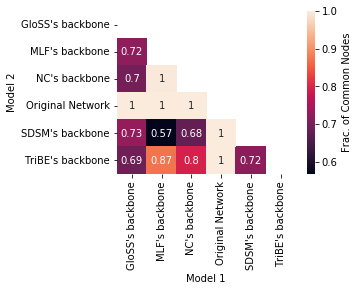

In [9]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4, 3))
pivot = df.pivot_table(index='Model 2', columns='Model 1', values='Frac. of Common Nodes')
mask = np.zeros(pivot.shape)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(pivot, 
                 annot=True, cbar_kws={'label': 'Frac. of Common Nodes'}, 
                 mask=mask)
fig.savefig('Instagram-BR/plots/Frac Common Nodes.pdf')

**Edge Weight Distribution**

In [21]:
list_models = ['Original','NC', 'TriBE', 'MLF', 'GloSS', 'SDSM']
dict_names = {'Original': 'Original Network', 'NC': "NC's backbone", 
              'TriBE': "TriBE's backbone", 'MLF': "MLF's backbone", 
              'GloSS': "GloSS's backbone", 'SDSM':"SDSM's backbone"}

#Base on the most aggressive method: GloSS
tribe = 1-0.05
sdsm= 0.001 
gloss = 0.1
mlf = 0.001
nc = 1-0.00001
list_edge_weight_dist = list()


#Original network
df = pd.read_csv('Instagram-BR/networks/network.edgelist', names=['u', 'v', 'w'], usecols=['w'], header=None, delimiter=' ')
list_edge_weight_dist.append(("Original Network", list(df['w'])))

#TriBE
df = pd.read_csv(PATH_Networks+'tribe/'+str(tribe)+'.edgelist',
                                 names=['u', 'v', 'w'], header=None, delimiter=' ')
list_edge_weight_dist.append(("TriBE's backbone", list(df['w'])))

# #NC
df = pd.read_csv(PATH_Networks+'nc/all_p_values.edgelist', 
                                 names=['u', 'v', 'w', 'confidence'], header=None, delimiter=',')
df = df[df['confidence'] > nc]
list_edge_weight_dist.append(("NC's backbone", list(df['w'])))


#MLF
df = pd.read_csv(PATH_Networks+'mlf/all_p_values.edgelist',
                                 names=['u', 'v', 'w','significance'], header=None, delimiter=',')
df['significance'] = math.e**(-df['significance'])
df = df[df['significance'] < mlf]
list_edge_weight_dist.append(("MLF's backbone", list(df['w'])))

#GLoSS Filter
df = pd.read_csv(PATH_Networks+'gloss/all_p_values.edgelist', 
                                 names=['u', 'v','p','w'], header=None,sep = ' ')
df = df[df['p'] < gloss]
list_edge_weight_dist.append(("GloSS's backbone", list(df['w'])))

#SDSM Filter
df = pd.read_csv(PATH_Networks+'sdsm/backbone_edgelist_'+str(sdsm)+'.csv',
                                 names=['u', 'v','w'], header=None,sep = ' ')
list_edge_weight_dist.append(("SDSM's backbone", list(df['w'])))

               u      v    w  confidence
0           17.0  768.0  3.0    1.000000
1           31.0  768.0  4.0    1.000000
2           71.0  768.0  4.0    1.000000
3          101.0  768.0  1.0    0.999999
4          203.0  768.0  3.0    1.000000
...          ...    ...  ...         ...
189813500   74.0  111.0  1.0    1.000000
189813501   35.0  111.0  4.0    1.000000
189813502   29.0  111.0  1.0    1.000000
189813503  154.0  407.0  1.0    1.000000
189813504   35.0   51.0  1.0    1.000000

[4285489 rows x 4 columns]


**Dist Plot** 

In [22]:
list_results = []
for model, dist in list_edge_weight_dist:
    print(model)
    for v in dist:
        list_results.append((model, v))
df = pd.DataFrame(list_results, columns=['Model', 'Edge Weight'])
df['Edge Weight'] = df['Edge Weight'].astype(int)

Original Network
TriBE's backbone
NC's backbone
MLF's backbone
GloSS's backbone
SDSM's backbone


In [ ]:
%matplotlib inline
sns.reset_orig()
for model in set(df['Model']):
    print(model)
    if model != 'Original':
        g=sns.displot(df[df['Model'].isin(['Original Network', model])],  height=2.5, aspect=1.3,
                    x="Edge Weight", hue="Model", binwidth=1, palette= "rocket_r", #stat = 'density',
                    log_scale=(False, True), legend=True)
        sns.move_legend(g, "upper right", bbox_to_anchor=(.58, 0.95), ncol=1, title=None, frameon=False)
        g.set(xlabel='Edge Weight', ylabel='# Edges')
        g.savefig('Instagram-BR/plots/'+model+'-Edge Weight Distributions.pdf')
